In [27]:
import rasterio
import numpy as np
import random
import math
import itertools
import os
import sys
import resnet as rs
import importlib
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import classifier_utilities as cu

In [73]:
importlib.reload(cu)

<module 'classifier_utilities' from '/host/Desktop/cnn_dev/florence_mapping/classifier_utilities.py'>

In [29]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [30]:
landsat_datasets, sentinel_datasets, dem_datasets, label_dataset = cu.load_data()

In [80]:
batch_size = 25
epochs = 200
num_classes = len(cu.indexed_dictionary)

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count-1# + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_bands,img_cols,img_rows)
print(input_shape)

(7, 64, 64)


In [5]:
pixels = cu.gen_balanced_pixel_locations(landsat_datasets[1:2], 80000, label_dataset=label_dataset, tile_size=tile_side)

100%|██████████| 1/1 [03:40<00:00, 220.30s/it]


In [6]:
train_px, val_px, test_px = cu.train_val_test_split(pixels, 0.7, 0.8)

In [76]:
print(len(train_px))
print(len(val_px))
print(len(test_px))

42451
14555
6550


In [ ]:
buckets = cu.pixel_balance(pixels, landsat_datasets[1:2], label_dataset)
for i in range(len(cu.indexed_dictionary)):
    print("{}:{}".format(cu.indexed_dictionary[i], buckets[i]))

In [56]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model

In [66]:
def make_model(in_shape):
    input_tensor = Input(shape = in_shape)
    
    conv_1 = SeparableConv2D(64, kernel_size=(3,3), activation='elu') (input_tensor)
    norm_1 = BatchNormalization() (conv_1)
    dropout_1 = Dropout(rate=0.5) (norm_1)
    pool_1 = MaxPooling2D() (dropout_1)
    
    
    conv_2 = SeparableConv2D(64, kernel_size=(3,3), activation='elu') (pool_1)
    norm_2 = BatchNormalization() (conv_2)
    pool_2 = MaxPooling2D() (norm_2)
    
    conv_3 = SeparableConv2D(64, kernel_size=(3,3), activation='elu') (pool_2)
    norm_3 = BatchNormalization() (conv_3)
    dropout_3 = Dropout(rate=0.5) (norm_3)
    pool_3 = MaxPooling2D() (dropout_3)

    
    flatten = Flatten() (pool_3)
    dense = Dense(128, activation='elu') (flatten)
    output = Dense(num_classes,activation='softmax') (dense)
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [81]:
model = rs.ResnetBuilder.build_resnet_50(input_shape, num_classes)
#model = make_model(input_shape)

In [ ]:
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(generator=cu.tile_generator(landsat_datasets[1:2], sentinel_datasets[1:2], dem_datasets[1:2], label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=cu.tile_generator(landsat_datasets[1:2], sentinel_datasets[1:2], dem_datasets[1:2], label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px)// batch_size)

Epoch 1/200
1698/1698 [==============================] - 524s 309ms/step - loss: 3.6215 - acc: 0.3515 - val_loss: 2.4858 - val_acc: 0.3301
Epoch 2/200
1698/1698 [==============================] - 481s 283ms/step - loss: 2.0989 - acc: 0.4071 - val_loss: 2.6230 - val_acc: 0.2922
Epoch 3/200
1698/1698 [==============================] - 479s 282ms/step - loss: 1.8925 - acc: 0.4400 - val_loss: 3.0999 - val_acc: 0.2663
Epoch 4/200
1698/1698 [==============================] - 480s 283ms/step - loss: 1.7808 - acc: 0.4693 - val_loss: 1.9344 - val_acc: 0.4223
Epoch 5/200
1698/1698 [==============================] - 479s 282ms/step - loss: 1.6937 - acc: 0.4947 - val_loss: 2.0698 - val_acc: 0.3945
Epoch 6/200
1698/1698 [==============================] - 478s 282ms/step - loss: 1.6265 - acc: 0.5178 - val_loss: 2.3175 - val_acc: 0.3551
Epoch 7/200
1698/1698 [==============================] - 481s 283ms/step - loss: 1.5735 - acc: 0.5385 - val_loss: 2.0294 - val_acc: 0.4170
Epoch 8/200
1698/1698 [====

### Evaluate model

663/663 [==============================] - 158s 238ms/step
[ 7 10  7 ... 13 13  6]
[ 6  6 10 ... 12 12  6]


/host/Desktop/cnn_dev/florence_mapping/classifier_utilities.py:651: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


ACCURACY
0.26699189291101055


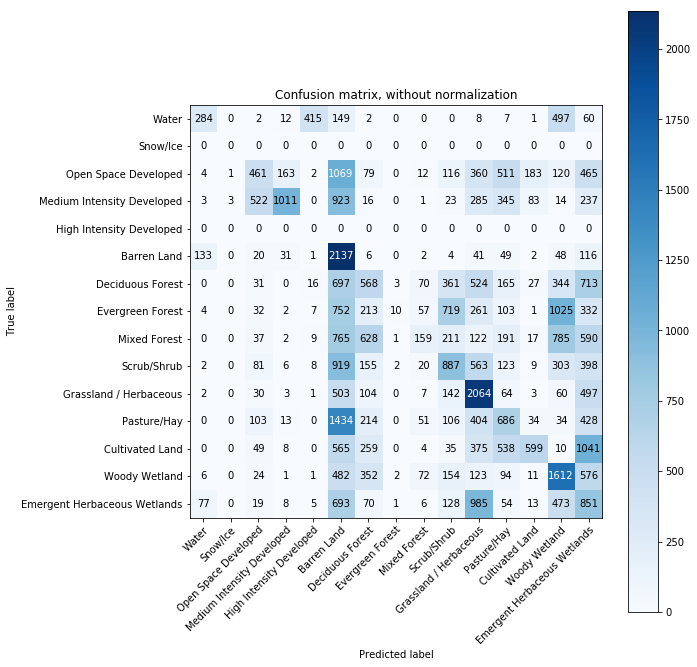

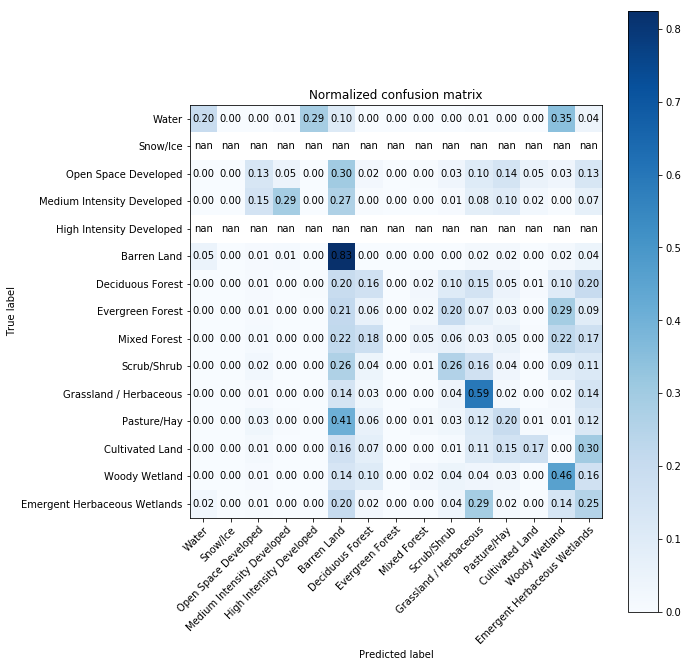

In [70]:
cu.evaluate_cnn(model, landsat_datasets[1:2], sentinel_datasets[1:2], dem_datasets[1:2], label_dataset, tile_side, train_px, old=False)